In [1]:
import torch
from torch import nn, save, load
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))   
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

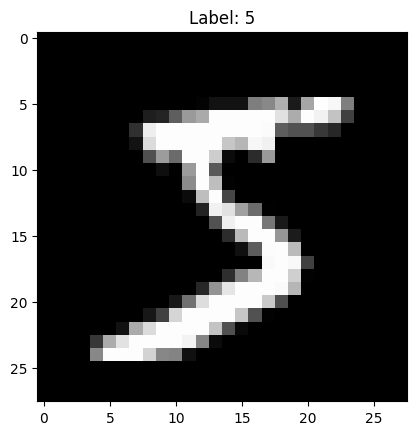

In [4]:
index = 0
plt.figure()
plt.imshow(train_dataset[index][0].squeeze(), cmap='grey')
plt.title(f"Label: {train_dataset[index][1]}") 
plt.show()

In [5]:
batch_size = 100
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)
test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)


In [6]:
# Example of how to iterate through a DataLoader
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

# Get a batch of data to verify the process
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Label batch shape: {train_labels.size()}")

Number of training batches: 600
Number of testing batches: 100
Feature batch shape: torch.Size([100, 1, 28, 28])
Label batch shape: torch.Size([100])


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
optimiser = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate (train_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = loss_fn(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest Epoch: {epoch}\tAverage loss: {test_loss:.10f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [13]:
for epoch in range(1, 51):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332184
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.837545
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.540922
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.341778
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.659231
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.352564

Test Epoch: 1	Average loss: 0.0000053108, Accuracy: 9634/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.415221
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.274143
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.172497
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.150152
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.252311
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.221131

Test Epoch: 2	Average loss: 0.0000087017, Accuracy: 9750/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.332839
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.136689
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.217122
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.096113
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.087011
Train Epoch: 3 [50000/6

Prediction: 0


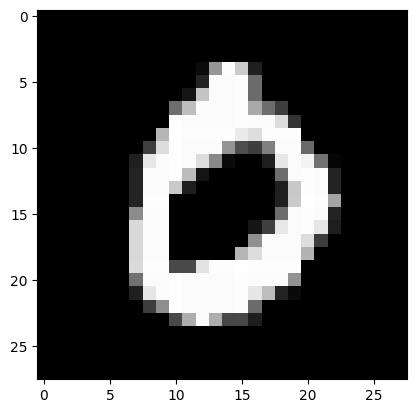

In [10]:
model.eval()
data , target = test_dataset[3]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f"Prediction: {prediction}")
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='grey')
plt.show()

In [14]:
from torchinfo import summary
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─Conv2d: 1-2                            [1, 20, 8, 8]             5,020
├─Dropout2d: 1-3                         [1, 20, 8, 8]             --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.49
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

In [15]:
model_path = './trained_CNN_mnist.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to ./trained_CNN_mnist.pth
